<a href="https://colab.research.google.com/github/thxxx/datascience/blob/master/hospital6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
# import 모음
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
import xgboost

import numpy as np
import graphviz

In [204]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
path = '/content/drive/MyDrive/data/dacon/'
os.listdir(path) # path에 뭐가 들어있는지 보여준다.

['submission_sample.csv',
 'test.csv',
 'train.csv',
 'hospital.ipynb',
 'hospital2.ipynb',
 'Untitled',
 'hospital3.ipynb',
 'hospital3.ipynb의 사본',
 'sub.csv',
 'sub.csv의 사본']

In [206]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [207]:
# 파일 전부 읽는다.
tdf = pd.read_csv(os.path.join(path + 'train.csv'), encoding='utf-8')
test_df = pd.read_csv(os.path.join(path + 'test.csv'), encoding='utf-8')
sdf = pd.read_csv(os.path.join(path + 'submission_sample.csv'), encoding='utf-8')

In [208]:
test_df.loc[test_df.inst_id == 430, ['instkind']] = 'dental_clinic'
test_df.loc[test_df.inst_id == 413, ['instkind']] = 'dental_clinic'
test_df[test_df['sido'].isna()]


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange


In [209]:
test_df

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,76680000.0,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,0.0,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,0.000000e+00,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,218399804.0,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,4.356296e+10,7.963862e+08,0.0,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same
1,5,NaN,jeju,149,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,0.0,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,0.0,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,0.000000e+00,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,0.0,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,6.545302e+10,1.450000e+07,0.0,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same
2,6,NaN,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,0.0,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,0.0,0.000000e+00,2.830632e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,15210270.0,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,2.777589e+10,4.288510e+08,0.0,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850652e+09,2.060989e+09,0.000000e+00,0.0,2.789663e+09,8.644533e+09,7.891338e+09,0.000000e+00,7.531944e+08,6.730264e+10,6.415297e+10,0.000000e+00,0.0,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,0.000000e+00,4.702837e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.975530e+09,2.112736e+09,0.000000e+00,0.0,2.862794e+09,1.204897e+10,1.126481e+10,0.000000e+00,7.841551e+08,3.920904e+10,3.601937e+10,0.000000e+00,0.0,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same
4,10,NaN,jeonbuk,26,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,2.296346e+10,1.534452e+09,0.000000e+00,2.573804e+09,0.0,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,0.0,4.921637e+10,2.503353e+10,1.720219e+10,2.418283e+10,9.976421e+09,2.268194e+10,1.492691e+10,4.348996e+10,0.000000e+00,4.067810e+10,1.871616e+10,1.802199e+09,0.000000e+00,3.925279e+09,0.0,4.614056e+09,8.847725e+09,7.868784e+09,1.764000e+08,9.789409e+08,6.085689e+10,6.014111e+10,5.467489e+08,0.0,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [210]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_df.employee1 = test_df.employee1.astype('str').str.replace(",", "").astype('float')
test_df.employee2 = test_df.employee2.astype('str').str.replace(",", "").astype('float')

In [211]:

# 오픈했는지 아닌지 OC open, close를 숫자 0,1로 바꿔준다.
tdf['OC'] = tdf['OC'].apply(lambda x: 1 if x=='open' else 0)

In [212]:
test_df.shape

(127, 58)

In [213]:
tdf.shape

(301, 58)

In [214]:
# revenue1이 NaN인건 다른 칼럼도 다 NaN인 row길래 드랍해버림
# 훨씬 코드를 잘짤 수 있다. 일단은 생각이 안나서 이따위로 함
# for i, x in enumerate(list(tdf['revenue1'].isna())):
#   if x == True:
#     print(tdf.drop(i, axis=0, inplace=True))
tdf.dropna(subset=['revenue1'], inplace=True)
test_df.dropna(subset=['revenue1'], inplace=True)

In [215]:
t_num = tdf.shape[0]
test_num = test_df.shape[0]

In [216]:
# OC는 정답이니까 따로 빼낸다!
train_label = tdf['OC']
tdf = tdf.drop(['OC'], axis=1)
test_df = test_df.drop(['OC'], axis=1)

In [217]:
#Combining the train and test dataset
tdf = tdf.append(test_df)

##Train data의 전처리 작업

In [218]:
# inst_id 는 아이디일 뿐인데 평가에 사용되는 듯해서 드랍해버렸다
tdf = tdf.drop(['inst_id'], axis=1)
# ownerChange의 Nan값들은 same으로 채운다. same이 241, change가 42개, NaN이 10개
tdf['ownerChange'] = tdf['ownerChange'].fillna('same')

# String same, change를 0,1로 바꾼다.
tdf['ownerChange'] = tdf['ownerChange'].apply(lambda x: 0 if x=='same' else 1 )
# bedCount, employee1,2 다 그냥 평균값으로 NaN 채움.
tdf['bedCount'] = tdf['bedCount'].fillna(tdf['bedCount'].mean()) # NaN인건 5개, 
tdf['employee1'] = tdf['employee1'].fillna(tdf['employee1'].mean())
tdf['employee2'] = tdf['employee2'].fillna(tdf['employee2'].mean())
tdf['openDate'] = tdf['openDate'].fillna(tdf['openDate'].mean())

In [219]:
# 원핫 인코딩 아주 간단한 방법
# tdf = pd.get_dummies(tdf, columns=['sido', 'instkind'])

In [220]:
tdf['instkind']

0          nursing_hospital
2          nursing_hospital
3          general_hospital
4          general_hospital
5          general_hospital
               ...         
122      traditional_clinic
123    traditional_hospital
124                hospital
125           dental_clinic
126                hospital
Name: instkind, Length: 418, dtype: object

In [221]:
# 레이블 인코딩 시도
le = LabelEncoder()
# sss = le.fit_transform(tdf['instkind'])
tdf['instkind'] = tdf['instkind'].astype('category').cat.codes
tdf['sido'] = tdf['sido'].astype('category').cat.codes

In [222]:
tdf

,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,73,20071228.0,175.000000,4,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.000000,64.000000,0
2,8,89,20161228.0,468.000000,4,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.000000,1.000000,0
3,10,141,20000814.0,353.000000,2,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.000000,663.000000,0
4,9,32,20050901.0,196.000000,2,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.000000,197.000000,0
5,9,155,20020501.0,243.000000,2,3.358054e+10,9.222997e+09,2.372791e+10,1.665533e+10,65414325.0,7.412694e+08,3.364622e+08,0.0,-4.622738e+07,5.635105e+09,5.481680e+09,6.634820e+08,1.534246e+08,1.864970e+10,1.849938e+10,1.364582e+08,0.0,0.000000e+00,1.849938e+10,1.718053e+10,0.000000e+00,0.000000e+00,0.000000e+00,3.664918e+09,3.433445e+10,9.839139e+09,2.409622e+10,1.638792e+10,125681154.0,4.500830e+08,4.155104e+08,0.0,7.468595e+07,4.869419e+09,4.725857e+09,1.976163e+08,1.435618e+08,2.212715e+10,2.186113e+10,1.910460e+08,0.0,0.000000e+00,2.186113e+10,1.708714e+10,2.000000e+07,0.000000e+00,0.000000e+00,5.879004e+09,397.000000,390.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [223]:
print(tdf.shape)
print(t_num, test_num)

(418, 56)
293 125


In [191]:
# 값들의 정규화. MinMaxScaler는 데이터 값을 0과 1사이 값으로 변환
scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(tdf)
tdf[tdf.columns] = scaler.fit_transform(tdf[tdf.columns])
print("HI!")

HI!


In [192]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 126
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sido                418 non-null    float64
 1   sgg                 418 non-null    float64
 2   openDate            418 non-null    float64
 3   bedCount            418 non-null    float64
 4   instkind            418 non-null    float64
 5   revenue1            418 non-null    float64
 6   salescost1          418 non-null    float64
 7   sga1                418 non-null    float64
 8   salary1             418 non-null    float64
 9   noi1                418 non-null    float64
 10  noe1                418 non-null    float64
 11  interest1           418 non-null    float64
 12  ctax1               418 non-null    float64
 13  profit1             418 non-null    float64
 14  liquidAsset1        418 non-null    float64
 15  quickAsset1         418 non-null    float64
 16  receivab

In [224]:
from sklearn.decomposition import PCA

# n_components는 pca로 반환할 차원의 수
pca = PCA(n_components=40)

#fit과 transform을 호출해 PCA변환 데이터 반환
pca.fit(tdf)
tdf = pca.transform(tdf)

In [225]:
tdf.shape

(418, 40)

In [226]:

columns = []
for i in range(40):
  columns.append(f"pca_com{i+1}")
pca_train = pd.DataFrame(tdf, columns=columns)


In [227]:
X_train = pca_train[:t_num]
X_test = pca_train[t_num:test_num+t_num]

In [228]:
X_test

,pca_com1,pca_com2,pca_com3,pca_com4,pca_com5,pca_com6,pca_com7,pca_com8,pca_com9,pca_com10,pca_com11,pca_com12,pca_com13,pca_com14,pca_com15,pca_com16,pca_com17,pca_com18,pca_com19,pca_com20,pca_com21,pca_com22,pca_com23,pca_com24,pca_com25,pca_com26,pca_com27,pca_com28,pca_com29,pca_com30,pca_com31,pca_com32,pca_com33,pca_com34,pca_com35,pca_com36,pca_com37,pca_com38,pca_com39,pca_com40
293,1.559807e+11,1.222015e+10,-3.964314e+10,-3.238686e+10,-7.244726e+09,6.462678e+10,8.036270e+09,-7.439657e+09,2.404391e+09,-2.119802e+09,6.738856e+09,5.658738e+09,-5.338061e+09,-6.744915e+09,-9.323690e+09,6.037324e+08,-3.086531e+09,-3.811554e+09,2.336174e+09,1.111567e+09,2.475925e+08,-2.963918e+09,-1.837379e+09,1.240718e+08,-1.375688e+08,-2.100080e+09,-6.119881e+07,-2.253866e+08,-1.269798e+09,3.237880e+08,-3.137060e+08,4.715912e+08,-5.778200e+07,3.472097e+08,1.181288e+08,-3.051845e+08,-8.168068e+07,4.383193e+07,-1.004995e+08,-4.860912e+07
294,1.384628e+11,-6.470863e+10,-4.558677e+10,-6.440682e+09,1.161468e+09,3.354720e+10,-1.408190e+10,4.759251e+08,4.213340e+09,-3.660287e+09,-5.225755e+09,-7.680327e+09,1.574396e+09,-7.771356e+09,3.424271e+09,-3.862898e+08,-9.709247e+08,-2.625043e+09,-4.505391e+09,2.008207e+09,-1.705558e+09,-5.647970e+08,2.721617e+09,-4.417239e+08,4.048113e+09,-1.328875e+09,-1.690331e+09,-1.844309e+09,2.061094e+09,6.246477e+08,2.016031e+08,-2.731945e+08,-1.717924e+08,3.265492e+08,2.730979e+07,5.512411e+08,7.179237e+07,-1.181992e+08,-1.729064e+07,-6.665301e+07
295,3.687335e+10,-7.378513e+08,3.266413e+09,-1.703247e+10,-9.595896e+09,3.955233e+10,-1.801605e+10,-4.161370e+09,-2.809230e+09,3.736187e+09,2.300889e+10,8.321358e+08,-3.437216e+09,1.570759e+10,1.489632e+10,-1.112820e+10,4.900258e+09,2.442956e+09,6.100696e+08,1.287847e+08,-4.542023e+08,4.196065e+08,4.076297e+08,6.217076e+08,1.346862e+08,-8.683823e+07,4.867339e+08,7.755717e+07,-2.840776e+08,-1.909869e+08,7.846207e+08,3.081931e+08,4.463168e+08,-6.991810e+07,9.062243e+08,2.071602e+08,2.310443e+08,1.363524e+08,1.606604e+07,-2.298082e+08
296,4.757887e+10,-7.465123e+10,3.549818e+10,1.615684e+10,-2.457829e+10,3.105342e+10,1.384274e+10,2.126708e+10,-6.562241e+09,-1.135554e+10,-2.007884e+08,-1.006456e+10,-4.421828e+09,-4.916426e+09,-2.084638e+09,2.910454e+09,1.451163e+08,6.864131e+09,3.074591e+09,2.566120e+09,7.142272e+08,1.715551e+09,-2.720931e+09,4.362235e+08,8.369117e+07,-1.355884e+09,1.270157e+09,9.554457e+08,-1.244061e+09,1.682655e+09,-7.122138e+08,4.286641e+08,2.949385e+08,-2.873948e+08,1.329044e+08,1.017989e+08,-1.365174e+08,1.206710e+08,-1.489044e+07,7.927853e+07
297,1.354591e+11,-4.166642e+10,-6.570614e+09,-1.747521e+10,1.125545e+10,-3.339595e+09,-6.524235e+09,5.467450e+09,-7.963692e+09,-9.721714e+09,5.451200e+09,2.743061e+09,-1.161107e+10,2.903658e+09,-8.949980e+09,8.423638e+08,-1.882044e+09,4.700630e+09,-1.557899e+09,-1.866648e+09,1.219953e+09,1.833936e+09,5.358351e+08,2.079685e+09,-6.586789e+07,-3.032876e+08,2.087483e+09,-1.245062e+09,1.379411e+09,-7.214304e+08,1.093186e+09,1.315598e+09,-1.561710e+09,2.867007e+06,-5.592874e+08,-1.892999e+08,2.289756e+08,1.304338e+07,1.394093e+08,3.514184e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2.305520e+10,1.217415e+10,7.845816e+09,-2.239703e+09,-8.666561e+08,1.444980e+10,2.052144e+10,-9.520781e+09,-4.151566e+08,-4.660538e+09,-3.246675e+09,-8.827881e+08,5.305909e+09,4.643238e+09,4.423747e+08,1.544783e+09,1.226017e+09,-1.193326e+08,-1.197416e+09,-1.345825e+08,5.828461e+08,-4.323329e+08,-1.280081e+08,-3.040305e+08,-1.579105e+09,8.324041e+07,1.328581e+06,-1.629689e+08,4.190751e+08,-1.622059e+08,4.550377e+08,9.651736e+07,-3.382270e+08,4.349180e+08,-3.838247e+08,1.372855e+08,1.044693e+07,-8.144840e+07,-2.047169e+07,6.020308e+07
414,-1.873763e+09,1.371636e+10,1.231524e+10,-1.157278e+10,2.962626e+09,-1.331199e+09,-1.930084e+09,-2.141733e+09,1.499888e+08,2.056185e+09,2.726118e+08,-2.760860e+09,-3.755718e+09,2.628

In [229]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier


xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, train_label)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [230]:
print(f"W_preds, {w_preds}")
print(f"w_pred_proba, {w_pred_proba}")

W_preds, [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
w_pred_proba, [0.9988973  0.87131655 0.99797946 0.9904612  0.94369787 0.98339534
 0.99715    0.9980159  0.89638305 0.99488914 0.99488914 0.9983773
 0.9996093  0.90954816 0.9854741  0.99980634 0.99920386 0.99810386
 0.9932861  0.9986816  0.99918205 0.9865204  0.9992704  0.99341875
 0.99908316 0.99915147 0.99366957 0.99591833 0.9977933  0.71300584
 0.99887115 0.9982874  0.99627554 0.9986344  0.9964569  0.9992575
 0.9997192  0.99350476 0.99979967 0.99957865 0.9996675  0.99922097
 0.9992176  0.98688716 0.9867208  0.99929523 0.99742776 0.99943334
 0.99929535 0.9997483  0.9986217  0.00775275 0.999374   0.9962901
 0.9976465  0.9993407  0.9580526  0.99979454 0.99638474 0.99925286
 0.9984144  0.9860766  0.9974396  0.9688028  0.99680907

In [231]:
w_preds = list(w_preds)
w_preds.insert(16, 1)
w_preds.insert(57, 1)

In [232]:
sdf['OC'] = w_preds
sdf.to_csv(path + 'sub.csv',index=False)

In [202]:
get_clf_eval(y_test, w_preds, w_pred_proba)

NameError: ignored

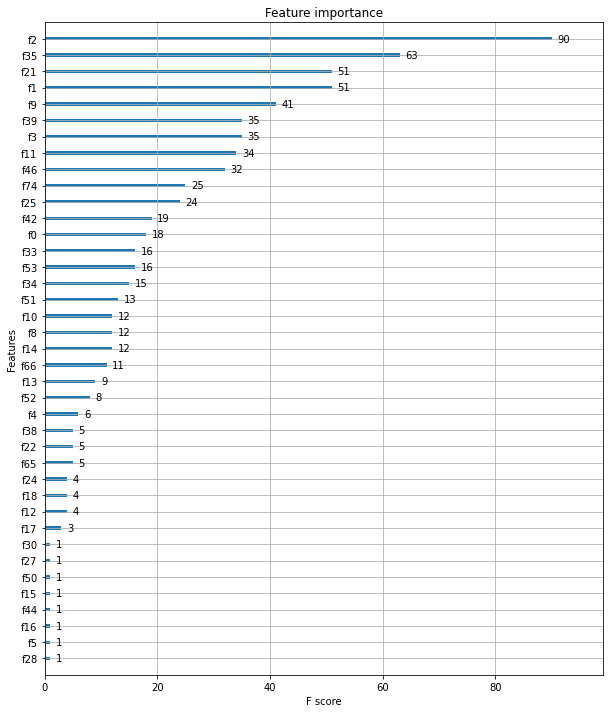

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
#사이킷런 래퍼 클래스를 입력하여도 무관
plot_importance(xgb_wrapper, ax=ax)

sgg   :  0.004515245
openDate   :  0.044308256
bedCount   :  0.0042471704
revenue1   :  0.022233978
salescost1   :  0.071807854
sga1   :  0.07336981
noe1   :  0.0058710813
interest1   :  0.022697141
ctax1   :  0.0013438266
profit1   :  0.025522456
liquidAsset1   :  0.06371887
quickAsset1   :  0.015257692
receivableS1   :  0.03920109
inventoryAsset1   :  0.015279754
nonCAsset1   :  0.05934666
tanAsset1   :  0.017477721
OnonCAsset1   :  0.031686913
liquidLiabilities1   :  0.015840055
shortLoan1   :  0.029634392
longLoan1   :  0.026941327
netAsset1   :  0.013154845
revenue2   :  0.009182289
salescost2   :  0.09167939
salary2   :  0.0029643816
interest2   :  0.016668065
ctax2   :  0.004834991
profit2   :  0.019987088
receivableS2   :  0.013221859
inventoryAsset2   :  0.015938327
OnonCAsset2   :  0.021281717
debt2   :  0.021490052
shortLoan2   :  0.01018972
surplus2   :  0.01669411
employee1   :  0.017161865
employee2   :  0.028522423
ownerChange   :  0.01241033
sido_jeonbuk   :  0.00743015

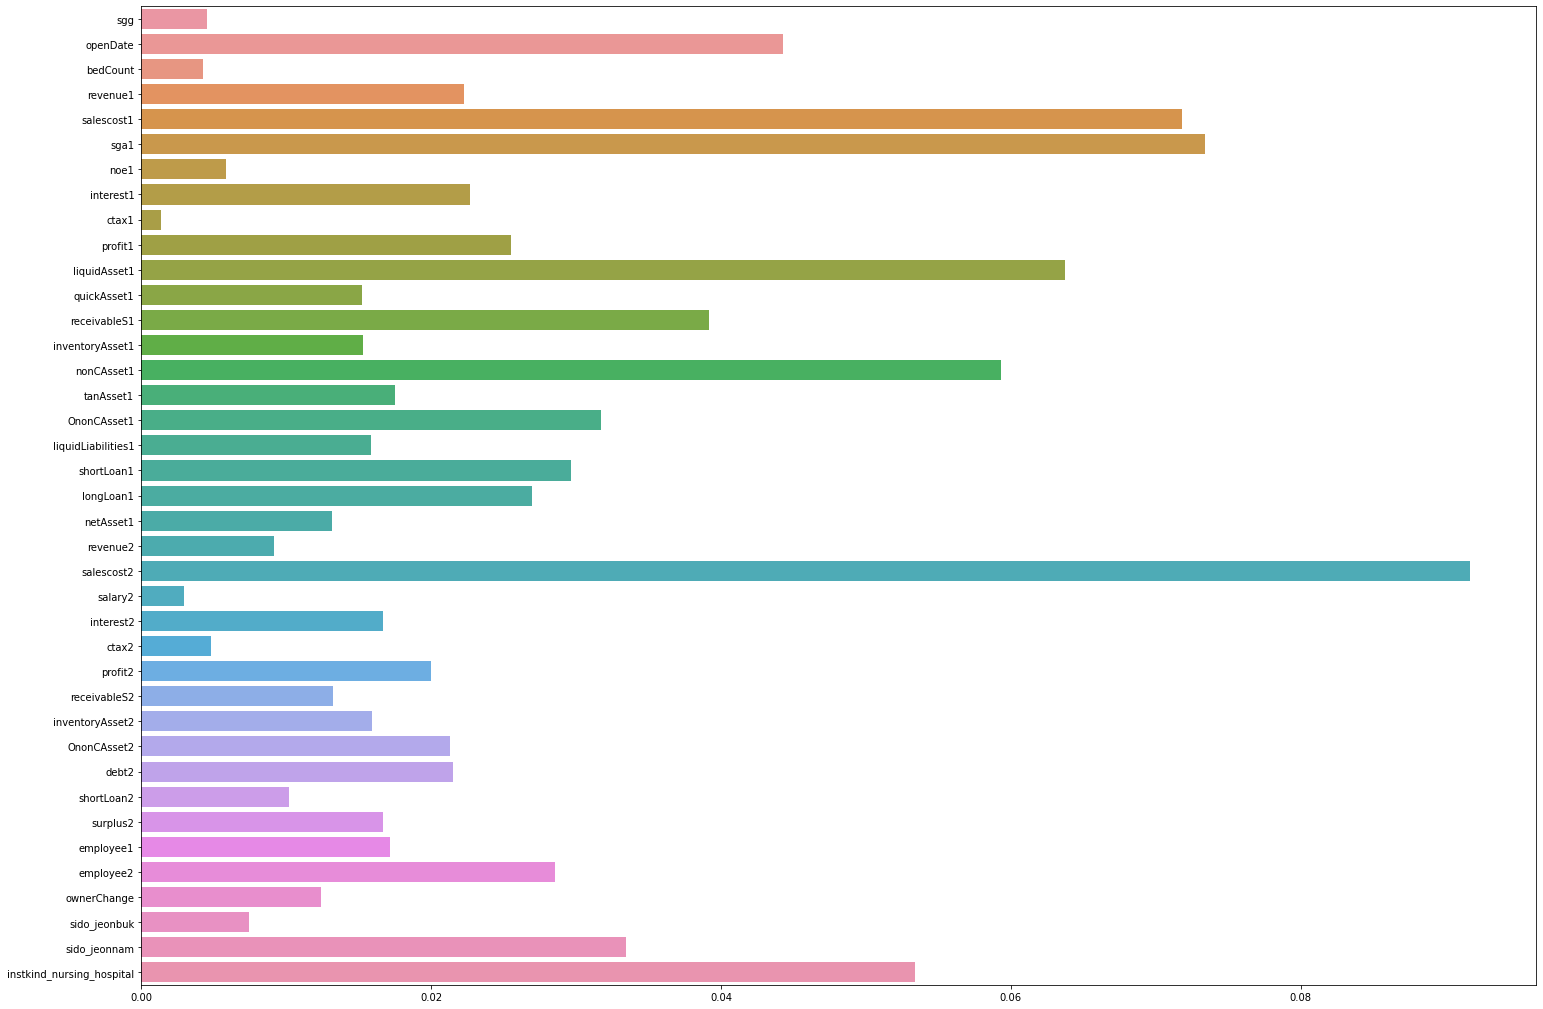

In [ ]:
# 각 피처별 중요도를 그래프로 보여준다.
plt.figure(figsize=(25,18))

# sns.barplot(x=tdf.columns, y=dt_clf.feature_importances_)

feature = []
scoress = []


for index, score  in enumerate(xgb_wrapper.feature_importances_):
  if score > 0:
    print(tdf.columns[index], "  : ", score)
    feature.append(tdf.columns[index])
    scoress.append(score)

sns.barplot(x=scoress, y=feature)


In [ ]:
dtrain = xgboost.DMatrix(data=X_train, label=y_train)
dtest = xgboost.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds=400

In [ ]:
wlist = [(dtrain, 'train'),(dtest,'test')]
xgbmodel = xgboost.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.616494	test-logloss:0.620079
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.551681	test-logloss:0.564622
[2]	train-logloss:0.497788	test-logloss:0.512051
[3]	train-logloss:0.451355	test-logloss:0.472223
[4]	train-logloss:0.412138	test-logloss:0.433945
[5]	train-logloss:0.3775	test-logloss:0.406473
[6]	train-logloss:0.347212	test-logloss:0.37846
[7]	train-logloss:0.321592	test-logloss:0.35298
[8]	train-logloss:0.298293	test-logloss:0.33188
[9]	train-logloss:0.277189	test-logloss:0.318104
[10]	train-logloss:0.259382	test-logloss:0.300846
[11]	train-logloss:0.242549	test-logloss:0.29078
[12]	train-logloss:0.228437	test-logloss:0.277332
[13]	train-logloss:0.214754	test-logloss:0.270439
[14]	train-logloss:0.200516	test-logloss:0.260474
[15]	train-logloss:0.187813	test-logloss:0.251565
[16]	train-logloss:0.176476	test-logloss:0.243728
[17]	train-loglo

In [ ]:
pred_probs = xgbmodel.predict(dtest)
print(np.round(pred_probs[:10],3))
print(pred_probs)

[0.998 0.986 0.823 0.995 0.996 0.998 0.999 0.998 0.975 0.993]
[0.99761957 0.9863629  0.82259923 0.9953713  0.9963013  0.9975184
 0.9989826  0.99817383 0.97467774 0.9926857  0.9958407  0.9928457
 0.9988937  0.98002964 0.99349797 0.87732154 0.99602616 0.99666107
 0.9984446  0.9965785  0.9964386  0.9967235  0.98212713 0.9993575
 0.99504024 0.9926629  0.9988003  0.99579644 0.9894767  0.8687018
 0.9985379  0.99882203 0.16730559 0.9753425  0.99800104 0.99809426
 0.9982784  0.9984382  0.9906697  0.9901238  0.99908066 0.99844295
 0.9829233  0.991621   0.99793303 0.99677175 0.99806136 0.99904686
 0.9987884  0.98926204 0.25936398 0.99868196 0.9975707  0.98127973
 0.99909794 0.9877763  0.99857616 0.98901576 0.98939717 0.9986755
 0.991402   0.99840015 0.96602404 0.9981688  0.9955924  0.97415006
 0.99468285 0.9969586  0.99920064 0.96258545 0.9961824  0.99776006
 0.9722062  0.9964875  0.99854386 0.9913045  0.9957665  0.99164224
 0.9762912  0.9446301  0.99924004 0.99632865 0.9972874  0.99311686
 0.99

In [ ]:
preds = [1 if x>0.5 else 0 for x in pred_probs]
for a in preds:
  if a == 0:
    print("zero")
for a in y_test:
  if a == 0:
    print("oo")

zero
zero
oo
oo
oo
oo


In [ ]:
print(accuracy_score(y_test, preds))

0.9318181818181818


In [ ]:
get_clf_eval(y_test, preds)

ValueError: ignored

0.9318181818181818


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}
# 랜덤포레스트분류기 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼 파라미터 {grid_cv.best_params_}")
print(f"최고 예측 정확도 {grid_cv.best_score_}")

최적 하이퍼 파라미터 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 0.9463639824861984


In [ ]:
# 위에서 얻은 최적 하이퍼 파라미터 대로 실행
rf_clf2 = RandomForestClassifier(random_state=0, max_depth = 6, min_samples_leaf = 8, min_samples_split = 8, n_estimators = 100)

rf_clf2.fit(X_train, y_train)
# 예측
pred2 = rf_clf2.predict(X_test)

In [ ]:
# 정확도!
print("정확도 : ",accuracy_score(y_test, pred2))

정확도 :  0.9545454545454546


NameError: ignored

In [ ]:
# 각 피처별 중요도를 그래프로 보여준다.
plt.figure(figsize=(25,18))

# sns.barplot(x=tdf.columns, y=dt_clf.feature_importances_)

feature = []
scoress = []


for index, score  in enumerate(rf_clf2.feature_importances_):
  if score > 0:
    print(tdf.columns[index], "  : ", score)
    feature.append(tdf.columns[index])
    scoress.append(score)

sns.barplot(x=scoress, y=feature)


AttributeError: ignored

<Figure size 1800x1296 with 0 Axes>

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

In [ ]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_df.employee1 = test_df.employee1.astype('str').str.replace(",", "").astype('float')
test_df.employee2 = test_df.employee2.astype('str').str.replace(",", "").astype('float')

In [ ]:
# inst_id 는 아이디일 뿐인데 평가에 사용되는 듯해서 드랍해버렸다
test_df = test_df.drop(['inst_id'], axis=1)
test_df = test_df.drop(['sido'], axis=1)
test_df = test_df.drop(['instkind'], axis=1)

# ownerChange의 Nan값들은 same으로 채운다. same이 241, change가 42개, NaN이 10개
test_df['ownerChange'] = test_df['ownerChange'].fillna('same')

# 오픈했는지 아닌지 OC open, close를 숫자 0,1로 바꿔준다.
test_df['OC'] = test_df['OC'].apply(lambda x: 1 if x=='open' else 0)

# String same, change를 0,1로 바꾼다.
test_df['ownerChange'] = test_df['ownerChange'].apply(lambda x: 0 if x=='same' else 1 )

# 원핫 인코딩 아주 간단한 방법
# test_df = pd.get_dummies(test_df, columns=['sido', 'instkind'])

# bedCount, employee1,2 다 그냥 평균값으로 NaN 채움.
test_df['bedCount'] = test_df['bedCount'].fillna(test_df['bedCount'].mean()) # NaN인건 5개, 
test_df['employee1'] = test_df['employee1'].fillna(test_df['employee1'].mean())
test_df['employee2'] = test_df['employee2'].fillna(test_df['employee1'].mean())
test_df['openDate'] = test_df['openDate'].fillna(test_df['openDate'].mean())

# 값들의 정규화. MinMaxScaler는 데이터 값을 0과 1사이 값으로 변환
scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(test_df)
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
print("HI!")

train_label = test_df['OC']
test_df = test_df.drop(['OC'], axis=1)

In [ ]:

#     print(tdf.drop(i, axis=0, inplace=True))
test_df.dropna(subset=['revenue1'], inplace=True)
test_df['openDate'] = test_df['openDate'].fillna(test_df['openDate'].mean())

In [ ]:
pred3 = rf_clf2.predict(test_df.values)

In [ ]:
pred3